We want to compute intra and inter network connectivty from covariance matrices, which should have been computed in `compare_maps.ipynb`

In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import itertools

import joblib
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

from bold_dementia.connectivity.matrices import plot_matrix
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.histograms import fast_hist
from bold_dementia.utils.iterables import unique, itersize

ATLAS = "schaeffer"
SOFT = False
matrices_path = Path(
    f"{config['data_dir']}/output/connectivity/atlas-{ATLAS}_strategy-high_pass-motion-wm_csf_motion-full_wm_csf-basic"
)

In [2]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")

n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

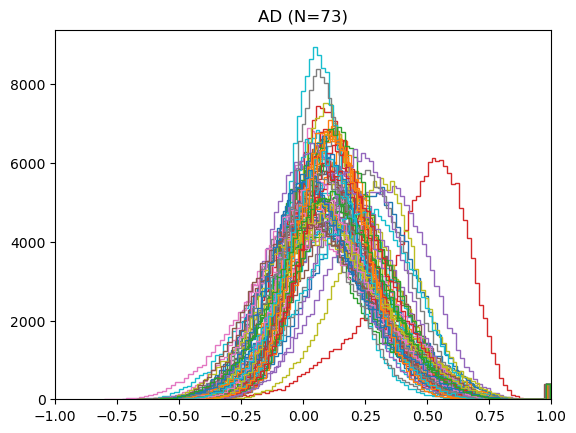

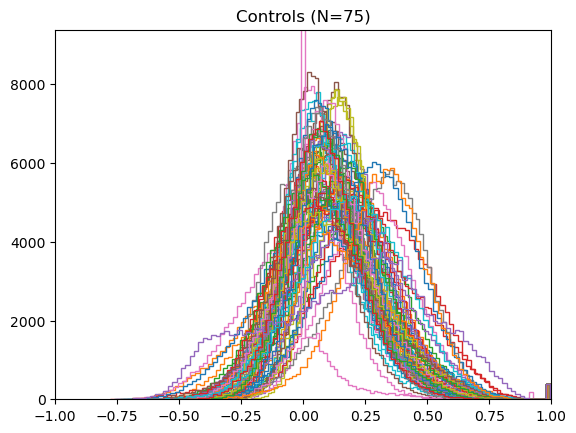

In [3]:
_, ax = fast_hist(AD_matrices, bins=100) 
ax.set_title(f"AD (N={n_AD})")
plt.show()

control_subsampled = control_matrices[::(n_controls//n_AD), :, :]
fig, ax2 = fast_hist(control_subsampled, bins=100) 
ax2.set_ylim(ax.get_ylim())
ax2.set_title(f"Controls (N={control_subsampled.shape[0]})")

plt.show()

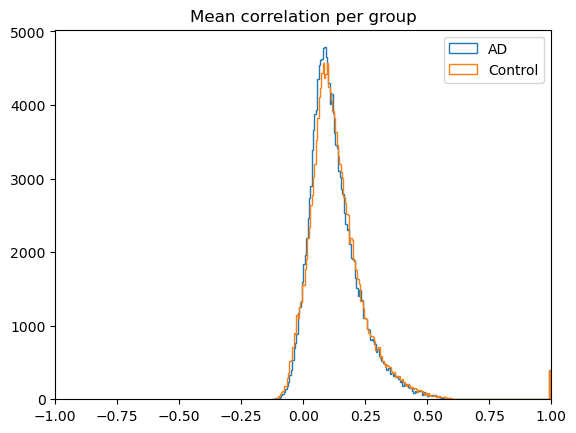

In [10]:
plt.hist(AD_matrices.mean(axis=0).flatten(), histtype="step", label="AD", bins=200)
plt.hist(control_matrices.mean(axis=0).flatten(), histtype="step", label="Control", bins=200)
plt.xlim(-1, 1)
plt.legend()
plt.title("Mean correlation per group")
plt.show()

In [5]:

def group_by_networks(macro_labels):
    networks = np.array(macro_labels)

    sort_index = np.argsort(networks)
    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label

    ticks.append(i + 1)
    return ticks, sort_index

In [6]:
ticks, sort_index = group_by_networks(atlas.macro_labels)

matrix_sort = np.ix_(sort_index, sort_index)
AD = AD_matrices.mean(axis=0)[matrix_sort]

control = control_matrices.mean(axis=0)[matrix_sort]
for mat in (AD, control):
    mat[list(range(n_regions)), list(range(n_regions))] = 0

In [7]:
network_to_idx = pd.Series(dict(zip(
    unique(atlas.macro_labels),
    list(itertools.pairwise(ticks))
)))
network_to_idx

Vis               (0, 52)
SomMot          (52, 143)
DorsAttn       (143, 189)
SalVentAttn    (189, 215)
Limbic         (215, 262)
Cont           (262, 339)
Default        (339, 400)
dtype: object

In [8]:
# Is mutual information symmetric?
tuple(itertools.product(network_to_idx.index, network_to_idx.index))

(('Vis', 'Vis'),
 ('Vis', 'SomMot'),
 ('Vis', 'DorsAttn'),
 ('Vis', 'SalVentAttn'),
 ('Vis', 'Limbic'),
 ('Vis', 'Cont'),
 ('Vis', 'Default'),
 ('SomMot', 'Vis'),
 ('SomMot', 'SomMot'),
 ('SomMot', 'DorsAttn'),
 ('SomMot', 'SalVentAttn'),
 ('SomMot', 'Limbic'),
 ('SomMot', 'Cont'),
 ('SomMot', 'Default'),
 ('DorsAttn', 'Vis'),
 ('DorsAttn', 'SomMot'),
 ('DorsAttn', 'DorsAttn'),
 ('DorsAttn', 'SalVentAttn'),
 ('DorsAttn', 'Limbic'),
 ('DorsAttn', 'Cont'),
 ('DorsAttn', 'Default'),
 ('SalVentAttn', 'Vis'),
 ('SalVentAttn', 'SomMot'),
 ('SalVentAttn', 'DorsAttn'),
 ('SalVentAttn', 'SalVentAttn'),
 ('SalVentAttn', 'Limbic'),
 ('SalVentAttn', 'Cont'),
 ('SalVentAttn', 'Default'),
 ('Limbic', 'Vis'),
 ('Limbic', 'SomMot'),
 ('Limbic', 'DorsAttn'),
 ('Limbic', 'SalVentAttn'),
 ('Limbic', 'Limbic'),
 ('Limbic', 'Cont'),
 ('Limbic', 'Default'),
 ('Cont', 'Vis'),
 ('Cont', 'SomMot'),
 ('Cont', 'DorsAttn'),
 ('Cont', 'SalVentAttn'),
 ('Cont', 'Limbic'),
 ('Cont', 'Cont'),
 ('Cont', 'Default'),
 (

In [9]:

# TODO Inversion is not necessary, we only need 1/det(S)
def integration(K, indices):
    integration_values = []
    for i_1, i_2 in itertools.pairwise(indices):
        integration_values.append(
            1/2 * np.log(
                npl.det(K[i_1:i_2, i_1:i_2])
            )
        )
    return integration_values

K_AD = npl.inv(AD)
I_AD = integration(K_AD, ticks)

pd.Series(dict(zip(unique(atlas.macro_labels), I_AD)))


/tmp/ipykernel_228698/1322645620.py:6: RuntimeWarning: invalid value encountered in log
  1/2 * np.log(


Vis                  NaN
SomMot               NaN
DorsAttn             NaN
SalVentAttn    11.626684
Limbic         15.678027
Cont                 NaN
Default        18.386541
dtype: float64